In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from math import ceil
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('..')
from utils.input_pipeline import get_image_folders
from utils.training import train
from utils.quantization import optimization_step, quantize, initial_scales

torch.cuda.is_available()

True

In [3]:
torch.backends.cudnn.benchmark = True

In [4]:
LEARNING_RATE = 1e-4  # learning rate for all possible weights
HYPERPARAMETER_T = 0.15  # hyperparameter for quantization

# Create data iterators

In [5]:
batch_size = 512

In [6]:
train_folder, val_folder = get_image_folders()

train_iterator = DataLoader(
    train_folder, batch_size=batch_size, num_workers=4,
    shuffle=True, pin_memory=True
)

val_iterator = DataLoader(
    val_folder, batch_size=256, num_workers=4,
    shuffle=False, pin_memory=True
)

# number of training samples
train_size = len(train_folder.imgs)
train_size

100000

# Model

In [7]:
from get_squeezenet import get_model

In [8]:
model, loss, optimizer = get_model(learning_rate=LEARNING_RATE)

# load pretrained model, accuracy ~52%
model.load_state_dict(torch.load('../vanilla_squeezenet/model.pytorch_state'))

#### keep copy of full precision kernels

In [9]:
# copy almost all full precision kernels of the model
all_fp_kernels = [
    Variable(kernel.data.clone(), requires_grad=True) 
    for kernel in optimizer.param_groups[1]['params']
]
# all_fp_kernels - kernel tensors of all convolutional layers 
# (with the exception of the first conv layer)

#### initial quantization 

In [10]:
# scaling factors for each quantized layer
initial_scaling_factors = []

In [11]:
# these kernels will be quantized
all_kernels = [kernel for kernel in optimizer.param_groups[1]['params']]

In [12]:
for k, k_fp in zip(all_kernels, all_fp_kernels):
    
    # choose initial scaling factors 
    w_p_initial, w_n_initial = initial_scales(k_fp.data)
    initial_scaling_factors += [(w_p_initial, w_n_initial)]
    
    # do quantization
    k.data = quantize(k_fp.data, w_p_initial, w_n_initial, t=HYPERPARAMETER_T)

#### parameter updaters

In [13]:
# optimizer for updating only all_fp_kernels
optimizer_fp = optim.Adam(all_fp_kernels, lr=LEARNING_RATE)

In [14]:
# optimizer for updating only scaling factors
optimizer_sf = optim.Adam([
    Variable(torch.FloatTensor([w_p, w_n]).cuda(), requires_grad=True) 
    for w_p, w_n in initial_scaling_factors
], lr=LEARNING_RATE)

# Train

In [15]:
n_epochs = 10
n_batches = ceil(train_size/batch_size)

# total number of batches in the train set
n_batches

196

In [16]:
%%time
def optimization_step_fn(model, loss, x_batch, y_batch):
    return optimization_step(
        model, loss, x_batch, y_batch, 
        optimizer_list=[optimizer, optimizer_fp, optimizer_sf],
        t=HYPERPARAMETER_T
    )
all_losses = train(
    model, loss, optimization_step_fn,
    train_iterator, val_iterator, n_epochs
)
# epoch logloss  accuracy    top5_accuracy time  (first value: train, second value: val)

0  17.403 12.707  0.223 0.231  0.471 0.475  116.700
1  8.803 6.580  0.240 0.240  0.492 0.498  123.032
2  5.118 3.968  0.223 0.238  0.471 0.493  112.761
3  3.746 3.387  0.235 0.276  0.486 0.540  112.560
4  3.373 3.207  0.263 0.293  0.526 0.557  112.431
5  3.164 3.146  0.293 0.304  0.562 0.569  112.807
6  3.038 3.080  0.313 0.319  0.586 0.586  112.461
7  2.944 3.097  0.330 0.308  0.603 0.576  112.531
8  2.872 3.177  0.343 0.305  0.616 0.570  112.617
9  2.809 2.844  0.352 0.356  0.626 0.628  112.724
CPU times: user 19min 58s, sys: 3min 11s, total: 23min 10s
Wall time: 19min


# Loss/epoch plots

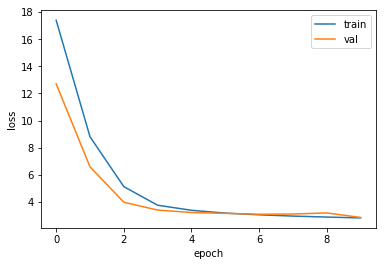

In [17]:
epochs = [x[0] for x in all_losses]
plt.plot(epochs, [x[1] for x in all_losses], label='train');
plt.plot(epochs, [x[2] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('loss');

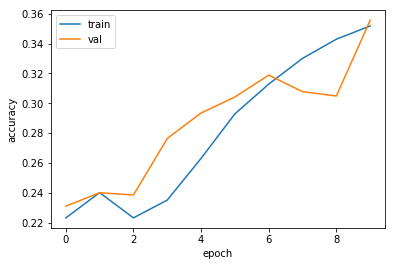

In [18]:
plt.plot(epochs, [x[3] for x in all_losses], label='train');
plt.plot(epochs, [x[4] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('accuracy');

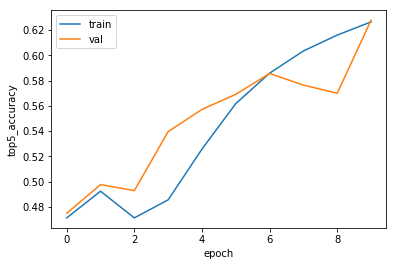

In [19]:
plt.plot(epochs, [x[5] for x in all_losses], label='train');
plt.plot(epochs, [x[6] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('top5_accuracy');

# Save

In [20]:
model.cpu();
torch.save(model.state_dict(), 'model_ternary_quantization.pytorch_state')